<a href="https://colab.research.google.com/github/lemurchik65/VfhECz15082000/blob/master/Lesson_5_GAN_parabolic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Нужна выборка для классификации. Для этого используем синтетическую выборку - точки на параболе. Нарисуем параболу и сгенерируем точки на ней.

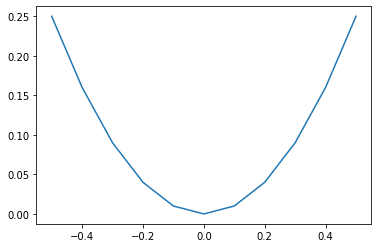

In [0]:
# The following line makes matplotlib compatible with Jupyter
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

def calculate(x):
    return x * x

x = np.asarray(list(range(-10, 11, 2)))/20
y = calculate(x)

plt.plot(x, y)
plt.show()

У нас есть функция, а теперь нам нужно сделать случайные точки, лежащие на функции. Это будет наша обучающая выборка.

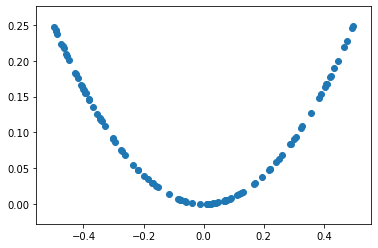

In [0]:
from numpy.random import rand
 
# generate randoms sample from x^2
def generate_real_samples(n=100):
    # generate random inputs in [-0.5, 0.5]
    x = rand(n) - 0.5
    y = calculate(x)
    # stack arrays
    x = x.reshape(n, 1)
    y = y.reshape(n, 1)
    return np.hstack((x, y))
 
data = generate_real_samples()
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Однако нам нужны и неправильные точки, которые не лежат на параболе. Это будет вторым классом объектов для нашего классификатора. Сгенерируем случайные точки в прямоугольнике.

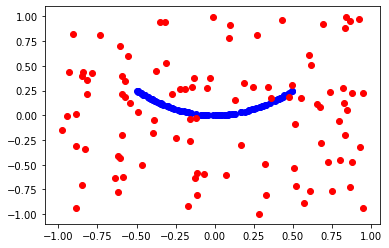

In [0]:
# generate n fake samples
def generate_fake_samples(n=100):
    # generate inputs in [-1, 1]
    x = -1 + rand(n) * 2
    y = -1 + rand(n) * 2
    # stack arrays
    x = x.reshape(n, 1)
    y = y.reshape(n, 1)
    return np.hstack((x, y))

fake = generate_fake_samples()
plt.scatter(data[:, 0], data[:, 1], color='blue')
plt.scatter(fake[:, 0], fake[:, 1], color='red')
plt.show()

Определим модель классификатора. Параметры понятны из аргументов функций. Не будем вдаваться в подробности, но моедль достаточно простая - всего 101 параметр.

In [0]:
# define the discriminator model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Сгенерируем слитую вместе выборку, указав классы (реальный объект, подделка). Теперь можно обучить модель и посмотреть как быстро она обучилась.

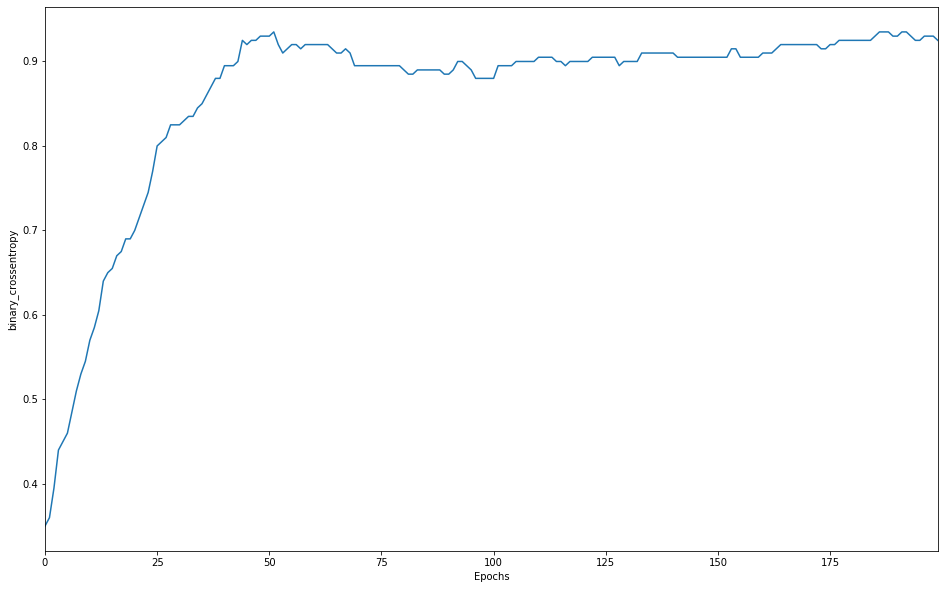

In [0]:
data_y = np.ones(len(data))
fake_y = np.zeros(len(fake))
# print(data.shape)
x_train = np.vstack((data, fake))
# print(x_train.shape)
# print(data_y.shape)
y_train = np.hstack((data_y, fake_y))
# print(y_train.shape)

history = model.fit(x_train, y_train, epochs = 200, verbose = 0)

plt.figure(figsize=(16,10))
plt.xlabel('Epochs')
plt.ylabel("binary_crossentropy")
plt.plot(history.epoch, history.history["acc"])
plt.xlim([0,max(history.epoch)])
plt.show()

Теперь у нас есть выборка, есть обученный классификатор и мы можем сделать генератор. Для этого выберем латентное пространство в виде гауссовского распределения с центром в нуле и дисперсией 0. Для примера нарисуем такое распределение для 2D случая.

[[-6.17414357e-01  1.85361455e-01  7.75771349e-01 -1.60816869e+00
  -4.29733969e-01  9.82175410e-01  1.00966330e+00  1.64342318e-01
  -4.90078208e-01 -1.27225332e+00]
 [-2.25721931e-01  5.74113820e-03  3.24004362e-01 -1.22621839e-02
   6.94149660e-01 -9.43481889e-01 -2.93229183e-01  9.19670389e-01
   7.70713425e-01 -7.19394408e-01]
 [ 4.12689076e-01  1.40344195e+00 -4.93826594e-01 -2.28845479e+00
  -4.86166946e-01 -8.44514195e-01 -5.28239387e-01  1.86838377e+00
   9.89568253e-01 -2.74246621e-01]
 [ 8.08801921e-01  3.91892679e-01 -4.76510901e-01  1.37900707e+00
   9.03749047e-01 -9.69649958e-02 -1.33841202e+00  2.97070339e-01
  -6.13109334e-01  6.89793718e-01]
 [-2.85006620e-01  1.62238162e-01  1.44287599e+00  3.62290009e-01
  -1.79449901e+00 -8.22684851e-01  9.22126530e-02 -6.60404652e-01
  -1.26032061e-01 -2.93963244e-01]
 [ 1.05091761e+00 -1.73583798e-01  1.34621352e-01 -1.18252473e-01
  -2.61644412e+00 -6.48922591e-01 -6.89800993e-01 -1.23941472e-01
  -1.70591272e+00 -6.92033259e-02

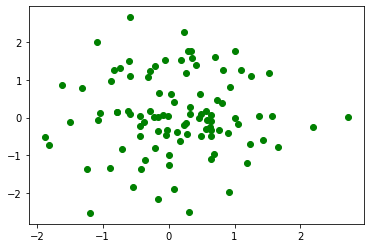

In [0]:
from numpy.random import randn

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

latent_example_2d = generate_latent_points(10, 100)
print(latent_example_2d)
print(len(latent_example_2d))
plt.scatter(latent_example_2d[:, 0], latent_example_2d[:, 1], color = "green")
plt.show()

In [0]:
latent_dim=5
n=2
x_input = randn(latent_dim * n)
print(x_input)

[ 0.76885519  1.1744322  -0.03492968  1.56913062 -1.21252776  1.78632316
  0.54296729  0.0090082   0.34930886  0.73467137]


Теперь определим сеть генератора, которая тоже будет параметризоваться количеством измерений. Выберем пятимерное латентное пространство. Слои примерно такие, как были в классификаторе.

In [0]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

generator_model = define_generator(5)
# summarize the model
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


Создадим функцию генератора нашего GAN, задача которого будет подавать точки латентного пространства в сеть генератора и выводить x и y, которые в итоге должны научиться попадать на параболу. Обучать его независимо мы не планиурем, поэтому мы его не компилируем.

In [0]:
# use the generator to generate n fake examples
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    return generator.predict(x_input)

А теперь возьмём необученную сеть и сгенерируем и нарисуем пары x и y. Удобно сразу сделать функцию визуализации, чтобы там присутствовала и модельная кривая.

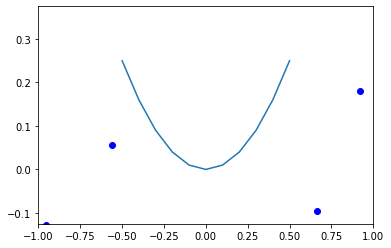

In [0]:
def summarize_performance(generator, latent_dim, n=100, savename = None):
    # prepare fake examples
    x_fake = generate_fake_samples(generator, latent_dim, n)
    # build model dependence
    x = np.asarray(list(range(-10, 11, 2)))/20
    y = calculate(x)
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    x_min = min(x) - 0.5 * (max(x) - min(x))
    x_max = max(x) + 0.5 * (max(x) - min(x))
    y_min = min(y) - 0.5 * (max(y) - min(y))
    y_max = max(y) + 0.5 * (max(y) - min(y))
    plt.ylim([y_min, y_max])
    plt.xlim([x_min, x_max])
    plt.plot(x, y)
    
    if savename is None:
        plt.show()
    else:
        plt.savefig(savename, format = "png")

summarize_performance(generator_model, 5)

По сути всё сделано, только сеть генератора вообще не тренирована, поэтому она выдала какой-то хаос из точек. Пришло время тренировать генератор. Для этого нужно соединить генератор и классификатор в единую цепь с латентным пространством на входе и бинарной классификацией на выходе. Только перед обучением запомним веса модели, чтобы можно было бы их восстановить.

In [0]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

gan_model = define_gan(generator_model, model)
# summarize gan model
gan_model.summary()
gan_model.save_weights("output/gan_initial.h5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential (Sequential)      (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


OSError: ignored

Теперь нужно выдавать вектора латентного пространства на вход и требовать, чтобы на выходе был класс точек параболы.  Если не получилось, то сеть будет обучаться, чтобы получилось, но обучаться будет только генераторная часть, ведь классификатор зафиксирован в настройках! Именно поэтому выборка включает только один класс. Сделаем для этого функцию обучения и запустим её. Загрузим веса из файла, хотя они и так загружены, но зато этот блок можно перезапускать и каждый раз будет обучаться с нуля.

In [0]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

#gan_model.load_weights("output/gan_initial.h5")
train_gan(gan_model, 5, n_epochs = 5000)

OSError: ignored

Визуализируем результат. Для этого сгенерируем точки на параболе.

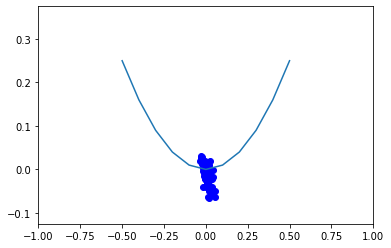

In [0]:
summarize_performance(generator_model, 5)

Точки сгрудились вместе где-то в районе параболы. Чем дальше мы будем обучать генератор, тем больше он будет пытаться выдавать константу. Исправим это тем, что будем дообучать дискриминатор с обучением генератора в соревновательном режиме. Для этого определим соответствующую функцию обучения, которая будет принимать дополнительно модель генератора и дискриминатора, ведь дискриминатор мы собираемся доучивать, а генератор нужен, чтобы генерировать ошибочный класс для обучения дискриминатора. Алгоритм похож на алгоритм train_gan, но в цикле еще нужно сделать обучающую выборку из точек на на параболе и точек, генерируемых генератором (все функции уже написаны выше). На этой выборке нужно переобучить дискриминатор, а затем так же, как и раньше, обучить GAN. Это будет одна эпоха.
В конце надо не забыть загрузить изначальные веса, чтобы сбросить сети в начальное необученное состояние.

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
    for i in range(n_epochs):
        fake = generate_fake_samples(g_model, latent_dim, n_batch)
       # print(latent_dim)
       # print(fake)
        data = generate_real_samples()
        print(i)
        data_y = np.ones(len(data))
        fake_y = np.zeros(len(fake))
        # print(data.shape)
        x_train = np.vstack((data, fake))
        y_train = np.hstack((data_y, fake_y))
        history = d_model.fit(x_train, y_train, epochs = 200, verbose = 0)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        
#gan_model.load_weights("output/gan_initial.h5")

Запустим обучение и посмотрим результат

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

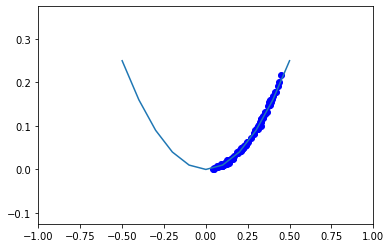

In [0]:
train(generator_model, model, gan_model, 5, n_epochs = 1500)
summarize_performance(generator_model, 5)

Получилось! Если не получилось, то запусти обучение еще раз и сеть дообучится. Наконец посмотрим процесс обучения по шагам. Для этого сделаем функцию вывода

In [0]:
from PIL import Image
import imageio

gan_model.load_weights("output/gan_initial.h5")
images = []
epochs_total = 20000
frames = 100
for i in range (1, frames):
    train(generator_model, model, gan_model, 5, n_epochs = int(epochs_total / frames))
    summarize_performance(generator_model, 5, savename = "output/tmp.png")
    plt.cla()
    image = Image.open("output/tmp.png")
    ar = np.asarray(image)
    images.append(ar)
kargs = { 'duration': 0.1 }
imageio.mimsave('output/gan_learning.gif', images, None, **kargs)
summarize_performance(generator_model, 5)

Выходные файлы с GIF анимацией находятся в папке output. Далее можно поэкспериментировать с настроечными параметрами обоих сетей, размерностью латентного пространства, методом обучения и т.д.